In [5]:
import nest
import nest.voltage_trace
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Настройка Ядра NEST ---
nest.ResetKernel()
nest.set_verbosity("M_ERROR")
print("NEST kernel reset and configured.")

# --- 2. Определение Параметров Сети ---
# Количество нейронов в каждой популяции
N_EC_Input = 50
N_DG = 100
N_CA3 = 100
N_CA1_Pyr = 100
N_CA1_Int = 20

# Параметры нейронов (модель iaf_psc_alpha)
neuron_params = {
    'V_th': -55.0,
    'V_reset': -70.0,
    'tau_m': 20.0,
    't_ref': 2.0,
    'E_L': -65.0,
    'C_m': 250.0
}

# Параметры синапсов (вес и задержка)
W_EC_DG = 100.0  # EC -> DG (сильный)
D_EC_DG = 1.0
P_EC_DG = 0.5

W_DG_CA3 = 200.0 # DG -> CA3 (мшистые волокна)
D_DG_CA3 = 2.0
P_DG_CA3 = 0.1

W_CA3_CA3 = 50.0 # CA3 -> CA3 (рекуррентные)
D_CA3_CA3 = 1.0
P_CA3_CA3 = 0.1

W_CA3_CA1_Pyr = 80.0 # CA3 -> CA1 Pyramidal
D_CA3_CA1_Pyr = 2.0
P_CA3_CA1_Pyr = 0.3

W_CA3_CA1_Int = 60.0 # CA3 -> CA1 Interneuron
D_CA3_CA1_Int = 1.0
P_CA3_CA1_Int = 0.4

W_CA1_Int_CA1_Pyr = -150.0 # CA1 Interneuron -> CA1 Pyramidal (тормозящие)
D_CA1_Int_CA1_Pyr = 1.0
P_CA1_Int_CA1_Pyr = 0.5

# --- НОВЫЕ ПАРАМЕТРЫ для EC -> CA3 ---
W_EC_CA3 = 50.0 # Вес меньше, чем EC -> DG
D_EC_CA3 = 1.0
P_EC_CA3 = 0.3 # Вероятность меньше, чем EC -> DG

# Параметры STDP-синапса
stdp_params = {
    "weight": 1.0,
    "delay": 2.0,
    "Wmax": 500.0,
    "mu_plus": 0.1,
    "mu_minus": 0.1,
    "tau_plus": 20.0,
    "tau_minus": 20.0,
    "lambda": 0.1,
    "alpha": 0.0
}

# Время симуляции
sim_time = 1000.0 # ms

# --- 3. Создание Узлов ---
print("Creating network nodes...")

ec_generators = nest.Create('poisson_generator', N_EC_Input, params={'rate': 500.0})

dg_neurons = nest.Create('iaf_psc_alpha', N_DG, params=neuron_params)
ca3_neurons = nest.Create('iaf_psc_alpha', N_CA3, params=neuron_params)
ca1_pyr_neurons = nest.Create('iaf_psc_alpha', N_CA1_Pyr, params=neuron_params)
ca1_int_neurons = nest.Create('iaf_psc_alpha', N_CA1_Int, params=neuron_params)

dg_detector = nest.Create('spike_recorder')
ca3_detector = nest.Create('spike_recorder')
ca1_pyr_detector = nest.Create('spike_recorder')
ca1_int_detector = nest.Create('spike_recorder')

target_ca1_pyr_node = ca1_pyr_neurons[0]
vm_ca1_pyr = nest.Create('voltmeter')
nest.Connect(vm_ca1_pyr, target_ca1_pyr_node)

source_ca3_node = ca3_neurons[0]

print("Nodes created.")

# --- 4. Соединение Сети ---
print("Connecting the network...")

# EC -> DG
conn_params_EC_DG = {'rule': 'pairwise_bernoulli', 'p': P_EC_DG, 'weight': W_EC_DG, 'delay': D_EC_DG}
nest.Connect(ec_generators, dg_neurons, conn_spec=conn_params_EC_DG, syn_spec={'model': 'static_synapse'})

# --- НОВАЯ СВЯЗЬ: EC -> CA3 ---
conn_params_EC_CA3 = {'rule': 'pairwise_bernoulli', 'p': P_EC_CA3, 'weight': W_EC_CA3, 'delay': D_EC_CA3}
nest.Connect(ec_generators, ca3_neurons, conn_spec=conn_params_EC_CA3, syn_spec={'model': 'static_synapse'})
print("Direct EC -> CA3 connections added.")

# DG -> CA3
conn_params_DG_CA3 = {'rule': 'pairwise_bernoulli', 'p': P_DG_CA3, 'weight': W_DG_CA3, 'delay': D_DG_CA3}
nest.Connect(dg_neurons, ca3_neurons, conn_spec=conn_params_DG_CA3, syn_spec={'model': 'static_synapse'})

# CA3 -> CA3 (Рекуррентные связи)
conn_params_CA3_CA3 = {'rule': 'pairwise_bernoulli', 'p': P_CA3_CA3, 'weight': W_CA3_CA3, 'delay': D_CA3_CA3}
nest.Connect(ca3_neurons, ca3_neurons, conn_spec=conn_params_CA3_CA3, syn_spec={'model': 'static_synapse'})

# CA3 -> CA1 Pyramidal
conn_params_CA3_CA1_Pyr = {'rule': 'pairwise_bernoulli', 'p': P_CA3_CA1_Pyr, 'weight': W_CA3_CA1_Pyr, 'delay': D_CA3_CA1_Pyr}
nest.Connect(ca3_neurons, ca1_pyr_neurons, conn_spec=conn_params_CA3_CA1_Pyr, syn_spec={'model': 'static_synapse'})

# CA3 -> CA1 Interneuron
conn_params_CA3_CA1_Int = {'rule': 'pairwise_bernoulli', 'p': P_CA3_CA1_Int, 'weight': W_CA3_CA1_Int, 'delay': D_CA3_CA1_Int}
nest.Connect(ca3_neurons, ca1_int_neurons, conn_spec=conn_params_CA3_CA1_Int, syn_spec={'model': 'static_synapse'})

# CA1 Interneuron -> CA1 Pyramidal (Тормозящие связи)
conn_params_CA1_Int_CA1_Pyr = {'rule': 'pairwise_bernoulli', 'p': P_CA1_Int_CA1_Pyr, 'weight': W_CA1_Int_CA1_Pyr, 'delay': D_CA1_Int_CA1_Pyr}
nest.Connect(ca1_int_neurons, ca1_pyr_neurons, conn_spec=conn_params_CA1_Int_CA1_Pyr, syn_spec={'model': 'static_synapse'})

# STDP-синапс между ОДНИМ нейроном CA3 и ОДНИМ пирамидальным нейроном CA1
print("Connecting STDP synapse...")
stdp_connection_ids = nest.Connect([source_ca3_node], [target_ca1_pyr_node],
                                   syn_spec={'model': 'stdp_synapse', **stdp_params})
initial_stdp_weight = nest.GetStatus(stdp_connection_ids, 'weight')[0]
print(f"Initial STDP synapse weight (CA3[{source_ca3_node}] -> CA1_Pyr[{target_ca1_pyr_node}]): {initial_stdp_weight:.2f}")

# Подключение детекторов спайков
print("Connecting spike detectors...")
nest.Connect(dg_neurons, dg_detector)
nest.Connect(ca3_neurons, ca3_detector)
nest.Connect(ca1_pyr_neurons, ca1_pyr_detector)
nest.Connect(ca1_int_neurons, ca1_int_detector)
print("Network connections complete.")

# --- 5. Запуск Симуляции ---
print(f"\nSimulating the network for {sim_time} ms...")
nest.Simulate(sim_time)
print("Simulation complete.")

# --- 6. Извлечение и Визуализация Результатов ---
print("Retrieving and plotting results...")

# Получаем данные о спайках
dg_events = nest.GetStatus(dg_detector, "events")[0]
ca3_events = nest.GetStatus(ca3_detector, "events")[0]
ca1_pyr_events = nest.GetStatus(ca1_pyr_detector, "events")[0]
ca1_int_events = nest.GetStatus(ca1_int_detector, "events")[0]

# Построение растровых графиков спайков для каждой популяции
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# DG Spikes
if len(dg_events['times']) > 0:
    axes[0].plot(dg_events['times'], dg_events['senders'], '.', markersize=2)
else:
    axes[0].text(sim_time/2, N_DG/2, 'No spikes in DG', horizontalalignment='center', verticalalignment='center', fontsize=12)
axes[0].set_title('Активность нейронов DG')
axes[0].set_ylabel('ID Нейрона')

# CA3 Spikes
if len(ca3_events['times']) > 0:
    axes[1].plot(ca3_events['times'], ca3_events['senders'], '.', markersize=2)
else:
    axes[1].text(sim_time/2, N_CA3/2, 'No spikes in CA3', horizontalalignment='center', verticalalignment='center', fontsize=12)
axes[1].set_title('Активность нейронов CA3')
axes[1].set_ylabel('ID Нейрона')

# CA1 Pyramidal Spikes
if len(ca1_pyr_events['times']) > 0:
    axes[2].plot(ca1_pyr_events['times'], ca1_pyr_events['senders'], '.', markersize=2)
else:
    axes[2].text(sim_time/2, N_CA1_Pyr/2, 'No spikes in CA1 Pyramidal', horizontalalignment='center', verticalalignment='center', fontsize=12)
axes[2].set_title('Активность пирамидальных нейронов CA1')
axes[2].set_ylabel('ID Нейрона')

# CA1 Interneuron Spikes
if len(ca1_int_events['times']) > 0:
    axes[3].plot(ca1_int_events['times'], ca1_int_events['senders'], '.', markersize=2)
else:
    axes[3].text(sim_time/2, N_CA1_Int/2, 'No spikes in CA1 Interneurons', horizontalalignment='center', verticalalignment='center', fontsize=12)
axes[3].set_title('Активность интернейронов CA1')
axes[3].set_ylabel('ID Нейрона')
axes[3].set_xlabel('Время (мс)')

plt.tight_layout()
plt.show()

# Построение графика мембранного потенциала выбранного нейрона CA1 Pyr
vm_events = nest.GetStatus(vm_ca1_pyr, "events")[0]
plt.figure(figsize=(12, 4))
plt.plot(vm_events['times'], vm_events['V_m'])
plt.title(f'Мембранный потенциал пирамидального нейрона CA1 (ID: {target_ca1_pyr_node})')
plt.xlabel('Время (мс)')
plt.ylabel('Потенциал мембраны (мВ)')
plt.grid(True)
plt.show()

# Получаем конечный вес STDP-синапса
final_stdp_weight = nest.GetStatus(stdp_connection_ids, 'weight')[0]
print(f"Конечный вес STDP-синапса (CA3[{source_ca3_node}] -> CA1_Pyr[{target_ca1_pyr_node}]): {final_stdp_weight:.2f}")

NEST kernel reset and configured.
Creating network nodes...
Nodes created.
Connecting the network...


NESTErrors.DictError: DictError in SLI function Connect_g_g_D_D: Unused dictionary items:  delay weight

Weights after simulation: ()


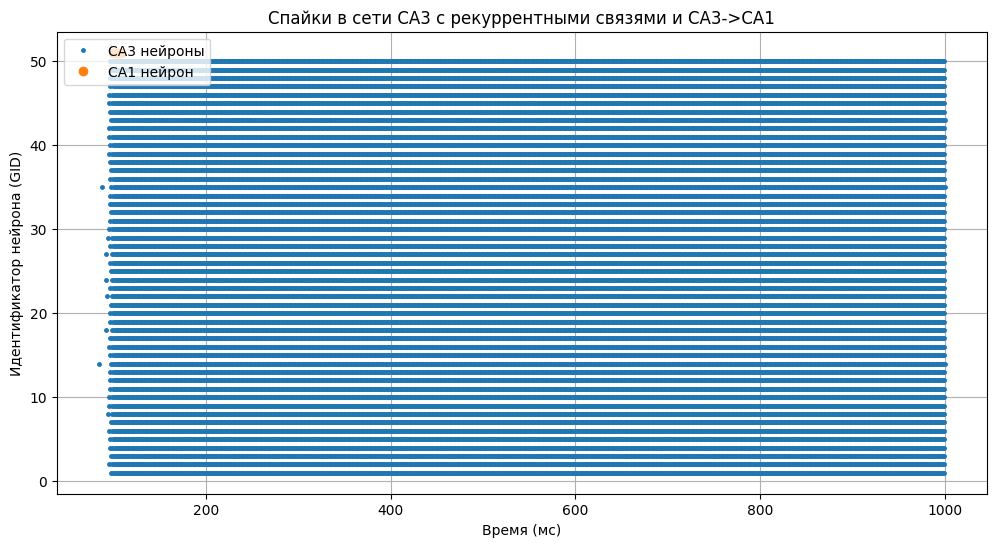

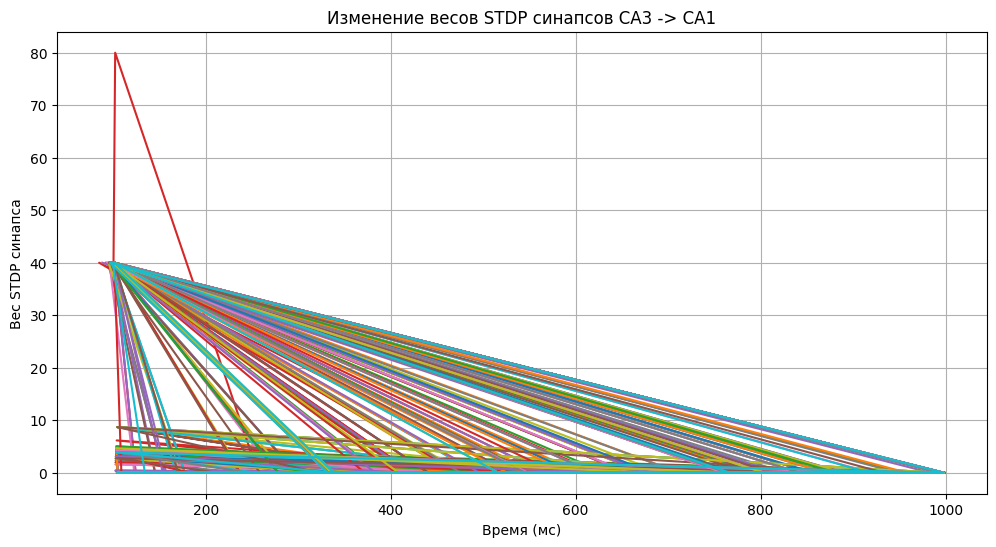

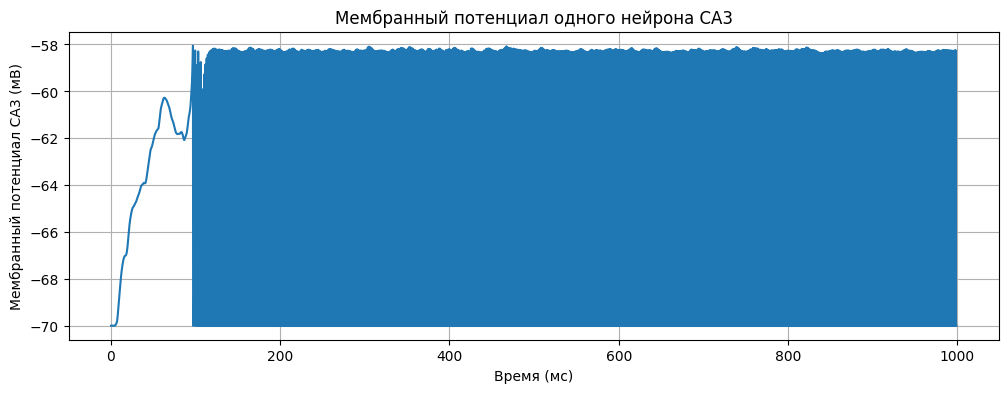

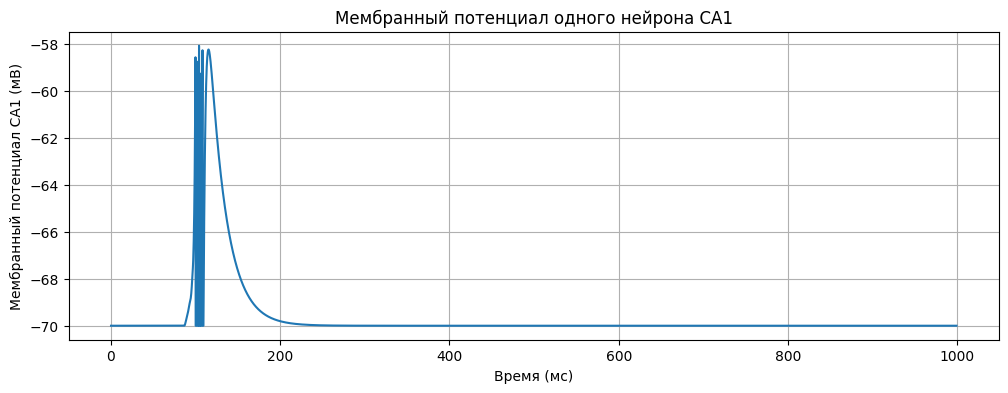

In [17]:
import nest
import matplotlib.pyplot as plt
import numpy as np

nest.ResetKernel()
nest.SetKernelStatus({"resolution": 0.1})

#-------задаем параметры сети-------
n_ca3_neurons = 50
n_ca1_neurons = 1

neuron_params = {
    "V_m": -70.0,  # Потенциал покоя
    "V_reset": -70.0,  # Потенциал сброса
    "V_th": -58.0,  # Порог срабатывания (немного выше, чем стандартные -50, может помочь увидеть Vm флуктуации)
    "tau_m": 20.0,  # мс, постоянная времени мембраны
    "E_L": -70.0,  # Потенциал утечки (равен потенциалу покоя)
    "t_ref": 1.0,  # мс, рефрактерный период
}

recurrent_weight_ca3 = 50.0
recurrent_delay_ca3 = 1.0

lambda_stdp = 1.0  # Базовая скорость обучения
mu_plus_stdp = 0.6  # Сила LTP
mu_minus_stdp = 0.1  # Сила LTD
tau_plus_stdp = 20.0  # мс, постоянная времени окна STDP (для обоих сторон)
Wmax_stdp = 80.0  # Максимальный вес синапса STDP

initial_weight_stdp = (Wmax_stdp + 0.0) / 2.0
# Начальный вес STDP синапса (середина диапазона)
delay_stdp = 2.0  # Задержка STDP синапса CA3 -> CA1

# Параметры входного генератора (Пуассоновский шум на CA3)

# Используем один генератор и соединим его с каждым нейроном CA3 с фиксированной вероятностью.
noise_rate = 1000.0  # Частота Пуассоновского генератора
noise_weight = 20.0  # Вес синапса от генератора шума
noise_delay = 2.0  # Задержка от генератора шума

simulation_time_ms = 1000.0  # Время симуляции в мс

# --- Создание узлов ---
# Создаём популяцию нейронов CA3 (возбуждающие IAF)
ca3_population = nest.Create("iaf_psc_alpha", n_ca3_neurons, params=neuron_params)

# Создаём один пирамидальный нейрон CA1 (возбуждающий IAF)
ca1_neuron = nest.Create("iaf_psc_alpha", n_ca1_neurons, params=neuron_params)

# Создаём генератор входного шума (Пуассоновский)
noise_generator = nest.Create("poisson_generator", params={"rate": noise_rate})

spike_recorder_ca3 = nest.Create("spike_recorder")  # Для CA3
spike_recorder_ca1 = nest.Create("spike_recorder")  # Для CA1
# Создаём рекордер для записи веса STDP синапса
weight_recorder_stdp = nest.Create("weight_recorder")

# Добавляем мультиметр для диагностики одного нейрона CA3
multimeter_ca3 = nest.Create("multimeter", params={"record_from": ["V_m"], "interval": 0.1})

# Добавляем мультиметр для диагностики одного нейрона CA1
multimeter_ca1 = nest.Create("multimeter", params={"record_from": ["V_m"], "interval": 0.1})

nest.SetDefaults("stdp_synapse", {
    "lambda": lambda_stdp,  # Базовая скорость обучения
    "mu_plus": mu_plus_stdp,  # Сила LTP
    "mu_minus": mu_minus_stdp,  # Сила LTD
    "tau_plus": tau_plus_stdp,  # Постоянная времени окна STDP
    "Wmax": Wmax_stdp,  # Максимальный вес синапса
})

# Соединяем генератор шума с популяцией CA3 (правило: все-со-всеми)
nest.Connect(noise_generator, ca3_population, syn_spec={"weight": noise_weight, "delay": noise_delay},
             conn_spec={"rule": "all_to_all"})

# Соединяем нейроны CA3 друг с другом (РЕКУРРЕНТНЫЕ СВЯЗИ, правило: все-со-всеми)
nest.Connect(ca3_population, ca3_population, syn_spec={"weight": recurrent_weight_ca3, "delay": recurrent_delay_ca3},
             conn_spec={"rule": "all_to_all"})

# Создаем копию stdp_synapse с логированием веса
nest.CopyModel(
    "stdp_synapse",
    "logged_stdp_synapse",
    {"weight_recorder": weight_recorder_stdp[0]}
)

# Используем эту модель для соединения
syn_dict_stdp_connection = {
    "synapse_model": "logged_stdp_synapse",
    "weight": initial_weight_stdp,
    "delay": delay_stdp,
}

synapses_ca3_ca1_stdp = nest.Connect(ca3_population, ca1_neuron, syn_spec=syn_dict_stdp_connection)

nest.Connect(ca3_population, spike_recorder_ca3)
nest.Connect(ca1_neuron, spike_recorder_ca1)

conns = nest.GetConnections(source=ca3_population, target=ca1_neuron, synapse_model='stdp_synapse')
weights = conns.get('weight')
print("Weights after simulation:", weights)

stdp_synapses_to_record = nest.GetConnections(source=ca3_population, target=ca1_neuron, synapse_model='stdp_synapse')

# Подключаем мультиметр к одному нейрону CA3 для диагностики Vm
nest.Connect(multimeter_ca3, ca3_population[0])  # Подключаем к первому нейрону CA3
# Подключаем мультиметр к одному нейрону CA3 для диагностики Vm
nest.Connect(multimeter_ca1, ca1_neuron)  # Подключаем к первому нейрону CA1

nest.Simulate(simulation_time_ms)

# --- Получение и построение графиков ---

# Получаем данные о спайках
events_ca3 = spike_recorder_ca3.get("events")
senders_ca3 = events_ca3["senders"]
ts_spikes_ca3 = events_ca3["times"]

events_ca1 = spike_recorder_ca1.get("events")
senders_ca1 = events_ca1["senders"]
ts_spikes_ca1 = events_ca1["times"]

# Получаем данные с мультиметра CA3
dmm_ca3_events = multimeter_ca3.get("events")
Vms_ca3 = dmm_ca3_events["V_m"]
ts_vm_ca3 = dmm_ca3_events["times"]
# Получаем данные с мультиметра CA3
dmm_ca1_events = multimeter_ca1.get("events")
Vms_ca1 = dmm_ca1_events["V_m"]
ts_vm_ca1 = dmm_ca1_events["times"]

# Получаем данные об изменении веса STDP синапсов
# Рекордер веса записывает время, идентификатор синапса и вес
weight_events = nest.GetStatus(weight_recorder_stdp)[0]["events"]
# weight_events = weight_recorder_stdp.get("events")[0] # Альтернативный синтаксис для NEST 3.x

# Получаем все STDP-синапсы
#stdp_connections = nest.GetConnections(source=ca3_population, target=ca1_neuron, synapse_model="stdp_synapse")
# Подключаем weight_recorder к этим синапсам
#nest.Connect(weight_recorder_stdp, stdp_connections)

recorded_weight_times = weight_events["times"]
recorded_synapse_ids = weight_events["senders"]
# В weight_recorder "senders" - это GID синапса
recorded_weights = weight_events["weights"]

# --- Построение графиков ---

# График спайков CA3 и CA1
plt.figure(figsize=(12, 6))
plt.plot(ts_spikes_ca3, senders_ca3, ".", markersize=5, label="CA3 нейроны")
plt.plot(ts_spikes_ca1, senders_ca1, ".", markersize=12, label="CA1 нейрон")
plt.xlabel("Время (мс)")
plt.ylabel("Идентификатор нейрона (GID)")
plt.title("Спайки в сети CA3 с рекуррентными связями и CA3->CA1")
plt.legend()
plt.grid(True)

# График изменения веса STDP синапсов CA3 -> CA1
plt.figure(figsize=(12, 6))
# Строим графики для каждого записанного синапса отдельно
# Сортируем по идентификатору синапса, чтобы рисовать линии для каждого синапса
sorted_indices = np.argsort(recorded_synapse_ids)
sorted_synapse_ids = recorded_synapse_ids[sorted_indices]
sorted_weight_times = recorded_weight_times[sorted_indices]
sorted_weights = recorded_weights[sorted_indices]

# Находим уникальные идентификаторы синапсов
unique_synapse_ids = np.unique(sorted_synapse_ids)

# Строим по одной линии для каждого синапса
for synapse_id in unique_synapse_ids:
    # Выбираем данные только для этого синапса
    synapse_indices = np.where(sorted_synapse_ids == synapse_id)[0]
    plt.plot(sorted_weight_times[synapse_indices], sorted_weights[synapse_indices], label=f'Синапс {synapse_id}')

plt.xlabel("Время (мс)")
plt.ylabel("Вес STDP синапса")
plt.title("Изменение весов STDP синапсов CA3 -> CA1")
# plt.legend() # Легенда может быть большой, если много синапсов
plt.grid(True)

# График мембранного потенциала одного нейрона CA3 (диагностика)
plt.figure(figsize=(12, 4))
plt.plot(ts_vm_ca3, Vms_ca3)
plt.xlabel("Время (мс)")
plt.ylabel("Мембранный потенциал CA3 (мВ)")
plt.title("Мембранный потенциал одного нейрона CA3")
plt.grid(True)

# График мембранного потенциала одного нейрона CA1 (диагностика)
plt.figure(figsize=(12, 4))
plt.plot(ts_vm_ca1, Vms_ca1)
plt.xlabel("Время (мс)")
plt.ylabel("Мембранный потенциал CA1 (мВ)")
plt.title("Мембранный потенциал одного нейрона CA1")
plt.grid(True)

# Сброс ядра NEST
nest.ResetKernel()


In [19]:
import nest
import matplotlib.pyplot as plt
import numpy as np

nest.ResetKernel()

# --- Параметры сети ---

n_dg_neurons = 50 # Количество гранулярных клеток в DG
ca3_total_neurons = 30 # Количество пирамидальных клеток в CA3
n_ca1_interneurons = 10 # Количество тормозных интернейронов в CA1

ec_noise_rate = 1000.0 # Частота Пуассоновского генератора ЭК в Гц (на один генератор)

# -----Параметры для синапсов от генератора ЭК----

# ЭК -> DG (медиальный перфорантный путь) - возбуждающий
weight_ec_to_dg = 8.0 # Вес синапса от ЭК к DG
delay_ec_to_dg = 2.0 # Задержка от ЭК к DG

# ЭК -> CA3 (латеральный перфорантный путь) - возбуждающий
weight_ec_to_ca3 = 10.0 # Вес синапса от ЭК к CA3
delay_ec_to_ca3 = 3.0 # Задержка от ЭК к CA3


# ---Параметры для синапсов моховидных волокон (DG -> CA3)---
weight_dg_to_ca3_mossy = 200.0 # Вес моховидных волокон DG -> CA3 (очень сильный!)
delay_dg_to_ca3_mossy = 4.0 # Задержка моховидных волокон
indegree_dg_to_ca3 = 5 # Каждый нейрон CA3 получает 5 связей от случайных нейронов DG

# ---Параметры для синапсов CA3 -> CA1 пирамидальный---
synaptic_weight_ca3_ca1_pyr = 200.0 # Вес синапса от CA3 к пирамидальному нейрону CA1 (возбуждающий)
synaptic_delay_ca3_ca1_pyr = 2.0 # Задержка синапса от CA3 к пирамидальному нейрону CA1

# ---Параметры для синапсов CA3 -> CA1 интернейроны---
weight_ca3_to_interneuron = 100.0 # Вес синапсов от CA3 к интернейонам (возбуждающий)
delay_ca3_to_interneuron = 1.5 # Задержка от CA3 к интернейонам

# ---Параметры для синапсов CA1 интернейроны -> CA1 пирамидальный---
synaptic_weight_ca1_inh_ca1_pyr = -20.0 # Вес тормозного синапса от интернейронов к пирамидальному нейрону (отрицательный!)
synaptic_delay_ca1_inh_ca1_pyr = 1.0 # Задержка тормозного синапса
#На графике нет гиперполяризации, потому что текущая модель использует торможение, основанное на инъекции тока, которое физически не может опустить мембранный потенциал ниже потенциала покоя.

simulation_time_ms = 2000.0 # ---Время симуляции в мс---

# --- Создание узлов ---

# ----Клетки---
# Создаём популяцию гранулярных клеток зубчатой извилины (DG)
dg_population = nest.Create("iaf_psc_alpha", n_dg_neurons)

# Создаём популяцию CA3 (возбуждающие)
ca3_population = nest.Create("iaf_psc_alpha", ca3_total_neurons)

# Создаём популяцию тормозных интернейронов в CA1
ca1_interneurons = nest.Create("iaf_psc_alpha", n_ca1_interneurons)

# Создаём одну CA1 клетку (пирамидальный нейрон, возбуждающий)
ca1_cell = nest.Create("iaf_psc_alpha", 1)

# ---Генераторы---
# Создаём генератор шума от Энторинальной коры (ЭК)
ec_noise_generator = nest.Create("poisson_generator")
ec_noise_generator.set({"rate": ec_noise_rate}) # Устанавливаем частоту генератора

# ---Устройства записи---
# Мультиметр для CA1 пирамидального
multimeter = nest.Create("multimeter", params={"record_from": ["V_m"], "interval": 0.1})
#  Мультиметры для проверки входящих токов в DG и CA3
multimeter_dg_check = nest.Create("multimeter", params={"record_from": ["V_m"], "interval": 0.1})
multimeter_ca3_check = nest.Create("multimeter", params={"record_from": ["V_m"], "interval": 0.1})


spike_rec_ca1 = nest.Create("spike_recorder") # Рекордер спайков для CA1 пирамидального
spike_rec_ca3 = nest.Create("spike_recorder") # Рекордер спайков для популяции CA3
spike_rec_ca1_interneurons = nest.Create("spike_recorder") # Рекордер спайков для интернейронов CA1
spike_rec_dg = nest.Create("spike_recorder") # Рекордер спайков для популяции DG

# --- Соединения ---

# ---Генераторы---

# Соединяем генератор шума ЭК с популяцией DG (возбуждающие синапсы)
# Используем rule "all_to_all", предполагая, что генератор имитирует множество входов
nest.Connect(ec_noise_generator, dg_population, syn_spec={"weight": weight_ec_to_dg, "delay": delay_ec_to_dg}, conn_spec={"rule": "all_to_all"})

# Соединяем генератор шума ЭК с популяцией CA3 (возбуждающие синапсы)
nest.Connect(ec_noise_generator, ca3_population, syn_spec={"weight": weight_ec_to_ca3, "delay": delay_ec_to_ca3}, conn_spec={"rule": "all_to_all"})

# ---Клетки---
# Соединяем популяцию DG с популяцией CA3 (моховидные волокна)
# Используем правило fixed_indegree на целевой популяции CA3
nest.Connect(dg_population, ca3_population, syn_spec={"weight": weight_dg_to_ca3_mossy, "delay": delay_dg_to_ca3_mossy}, conn_spec={"rule": "fixed_indegree", "indegree": indegree_dg_to_ca3})

# Соединяем популяцию CA3 с популяцией тормозных интернейронов CA1 (возбуждающие синапсы)
nest.Connect(ca3_population, ca1_interneurons, syn_spec={"weight": weight_ca3_to_interneuron, "delay": delay_ca3_to_interneuron}, conn_spec={"rule": "all_to_all"})

# Соединяем популяцию CA3 с CA1 нейроном (возбуждающие синапсы)
nest.Connect(ca3_population, ca1_cell, syn_spec={"weight": synaptic_weight_ca3_ca1_pyr, "delay": synaptic_delay_ca3_ca1_pyr}, conn_spec={"rule": "all_to_all"})

# Соединяем тормозные интернейроны CA1 с пирамидальным нейроном CA1 (тормозные синапсы)
nest.Connect(ca1_interneurons, ca1_cell, syn_spec={"weight": synaptic_weight_ca1_inh_ca1_pyr, "delay": synaptic_delay_ca1_inh_ca1_pyr}, conn_spec={"rule": "all_to_all"})

# ---Соединяем устройства записи---
nest.Connect(multimeter, ca1_cell) # Мультиметр к CA1 пирамидальному (вход)
nest.Connect(ca1_cell, spike_rec_ca1) # CA1 пирамидальный к рекордеру (выход)
nest.Connect(ca3_population, spike_rec_ca3) # Популяция CA3 к рекордеру спайков CA3
nest.Connect(ca1_interneurons, spike_rec_ca1_interneurons)# Интернейроны CA1 к их рекордеру спайков
nest.Connect(dg_population, spike_rec_dg) # Популяция DG к их рекордеру спайков
nest.Connect(ms_theta_generator, generator_recorder) # Соединяем генератор МС с рекордером для проверки

# Подключаем мультиметр к первому нейрону в популяции DG
nest.Connect(multimeter_dg_check, dg_population[0])
# Подключаем мультиметр к первому нейрону в популяции CA3
nest.Connect(multimeter_ca3_check, ca3_population[0])

# --- Запуск симуляции ---

nest.Simulate(simulation_time_ms)

# --- Получение и построение графиков ---

# Получаем данные с мультиметра CA1
dmm_events = multimeter.get("events") # Получаем весь словарь событий
Vms = dmm_events["V_m"] # Получаем список значений Vm по ключу "V_m"
ts_vm = dmm_events["times"] # Получаем список времен по ключу "times"

# Получаем данные со всех рекордеров
events_ca1_pyr = spike_rec_ca1.get("events") # Получаем словарь событий
senders_ca1_pyr = events_ca1_pyr["senders"]
ts_spikes_ca1_pyr = events_ca1_pyr["times"]

events_ca3 = spike_rec_ca3.get("events") # Получаем словарь событий
senders_ca3 = events_ca3["senders"]
ts_spikes_ca3 = events_ca3["times"]

events_ca1_interneurons = spike_rec_ca1_interneurons.get("events")
senders_ca1_interneurons = events_ca1_interneurons["senders"]
ts_spikes_ca1_interneurons = events_ca1_interneurons["times"]

events_dg = spike_rec_dg.get("events") # Получаем словарь событий
senders_dg = events_dg["senders"]
ts_spikes_dg = events_dg["times"]

#  Получаем данные с мультиметров проверки
dmm_dg_events = multimeter_dg_check.get("events")
Vms_dg_check = dmm_dg_events["V_m"]
ts_vm_dg_check = dmm_dg_events["times"]

dmm_ca3_events = multimeter_ca3_check.get("events")
Vms_ca3_check = dmm_ca3_events["V_m"]
ts_vm_ca3_check = dmm_ca3_events["times"]

# График мембранного потенциала CA1 пирамидального
plt.figure(figsize=(12, 4))
plt.plot(ts_vm, Vms)
plt.xlabel("Время (мс)")
plt.ylabel("Мембранный потенциал (мВ)")
plt.title("Мембранный потенциал CA1 пирамидального нейрона")
plt.grid(True)

# График спайков (Raster Plot) для всех нейронов
plt.figure(figsize=(12, 6))
plt.plot(ts_spikes_ca3, senders_ca3, ".", markersize=2, label="CA3 нейроны")
plt.plot(ts_spikes_ca1_interneurons, senders_ca1_interneurons, ".", markersize=4, label="CA1 интернейроны")
plt.plot(ts_spikes_ca1_pyr, senders_ca1_pyr, ".", markersize=6, label="CA1 пирамидальный нейрон")
plt.plot(ts_spikes_dg, senders_dg, ".", markersize=2, label="DG нейроны")
plt.xlabel("Время (мс)")
plt.ylabel("Идентификатор нейрона (GID)",fontsize='xx-large')
plt.title("Спайки в сети (DG, CA3, CA1 интернейроны, CA1 пирамидальный)",fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.grid(True)

# График мембранного потенциала одного нейрона DG
plt.figure(figsize=(12, 4))
plt.plot(ts_vm_dg_check, Vms_dg_check)
plt.xlabel("Время (мс)")
plt.ylabel("Мембранный потенциал (мВ)")
plt.title("Vm одного нейрона DG")
plt.grid(True)

# График мембранного потенциала одного нейрона CA3
plt.figure(figsize=(12, 4))
plt.plot(ts_vm_ca3_check, Vms_ca3_check)
plt.xlabel("Время (мс)")
plt.ylabel("Мембранный потенциал (мВ)")
plt.title("Vm одного нейрона CA3")
plt.grid(True)

# Сброс ядра NEST
nest.ResetKernel()

NESTErrors.InvalidNodeCollection: sources and targets must be valid NodeCollections.: InvalidNodeCollection: sources and targets must be valid NodeCollections. in SLI function Connect_g_g_D_D: 